In [1]:
import horton
import numpy as np
import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [91]:
def do_run(targetdist, pseudo, zsuper, gridpoints):
    horton.log.set_level(0)
    pseudo = np.array(pseudo)*1.0
    targetdist = float(targetdist)
    mol = horton.IOData(title='test')
    mol.coordinates = np.array([[-targetdist/2., 0.0, 0.0], [targetdist/2., 0.0, 0.0]]) * horton.angstrom
    mol.numbers = np.array([7, 7])
    mol.pseudo_numbers = pseudo
    
    basisset = 'STO-3G'
    #basisset='6-31G(d)'
    basisset = 'def2-TZVP'
    obasis = horton.get_gobasis(mol.coordinates, mol.numbers, basisset)
    for z in zsuper:
        obasis2 = horton.get_gobasis(mol.coordinates, np.array([z]*2), basisset)
        obasis = obasis.concatenate(obasis2)
    
    olp = obasis.compute_overlap()
    kin = obasis.compute_kinetic()
    na = obasis.compute_nuclear_attraction(mol.coordinates, mol.pseudo_numbers)
    er = obasis.compute_electron_repulsion()
    
    orb_alpha = horton.Orbitals(obasis.nbasis)
    orb_beta = horton.Orbitals(obasis.nbasis)

    # Initial guess
    one = kin + na
    horton.guess_core_hamiltonian(olp, one, orb_alpha, orb_beta)
    
    external = {'nn': horton.compute_nucnuc(mol.coordinates, mol.pseudo_numbers)}
    terms = [
        horton.UTwoIndexTerm(kin, 'kin'),
        horton.UDirectTerm(er, 'hartree'),
        horton.UExchangeTerm(er, 'x_hf'),
        horton.UTwoIndexTerm(na, 'ne'),
    ]
    ham = horton.UEffHam(terms, external)
    
    #LDA
    #grid = horton.BeckeMolGrid(mol.coordinates, mol.numbers, mol.numbers, 'fine', mode='keep', random_rotate=False)
    #terms = [
    #    horton.UTwoIndexTerm(kin, 'kin'),
    #    horton.UGridGroup(obasis, grid, [
    #        horton.UBeckeHartree(lmax=8),
    #        horton.ULibXCLDA('x'),
    #        horton.ULibXCLDA('c_vwn'),
    #    ]),
    #    horton.UTwoIndexTerm(na, 'ne'),
    #]
    #ham = horton.UEffHam(terms, external)
    
    #PBE
    #terms = [
    #    horton.UTwoIndexTerm(kin, 'kin'),
    #    horton.UDirectTerm(er, 'hartree'),
    #    horton.UGridGroup(obasis, grid, [
    #        horton.ULibXCGGA('x_pbe'),
    #        horton.ULibXCGGA('c_pbe'),
    #    ]),
    #    horton.UTwoIndexTerm(na, 'ne'),
    #]
    #ham = horton.UEffHam(terms, external)
    
    
    converged = False
    for solver in (horton.CDIISSCFSolver, horton.EDIIS2SCFSolver,horton.ODASCFSolver,  horton.EDIISSCFSolver, ):
        try:
            occ_model = horton.AufbauOccModel(7, 7)
        
            occ_model.assign(orb_alpha, orb_beta)
            dm_alpha = orb_alpha.to_dm()
            dm_beta = orb_beta.to_dm()
            scf_solver = solver(1e-7, maxiter=100)
            scf_solver(ham, olp, occ_model, dm_alpha, dm_beta)
            converged = True
        except:
            continue
        if converged:
            break
    if not converged:
        raise horton.NoSCFConvergence('no conv')
    
    rho_grid = obasis.compute_grid_density_dm(dm_alpha, gridpoints)
    rho_grid += obasis.compute_grid_density_dm(dm_beta, gridpoints)
    
    return rho_grid
def get_partial_derivative(targetdist, pseudo, zsuper, gridpoints, site):
    pseudo = np.array(pseudo)
    
    delta = 0.05
    if pseudo[site] - delta/2. < 0:
        # forward finite differences only
        rho = do_run(targetdist, pseudo, zsuper, gridpoints)    
        
        pseudonew = pseudo.copy()
        pseudonew[site] += delta
        rhoup = do_run(targetdist, pseudonew, zsuper, gridpoints)
        
        deriv = (rhoup - rho) / delta
    else:
        # central FD
        pseudonew = pseudo.copy()
        pseudonew[site] += delta/2.
        rhoup = do_run(targetdist, pseudonew, zsuper, gridpoints)
        
        pseudonew = pseudo.copy()
        pseudonew[site] -= delta/2.
        rhodn = do_run(targetdist, pseudonew, zsuper, gridpoints)
        
        deriv = (rhoup - rhodn)/delta
    return deriv

In [75]:
def get_grid():
    xs = np.linspace(-3, 3, 100)
    ys = xs.copy()*0
    zs = xs.copy()*0
    return np.copy(np.column_stack((xs, ys, zs)))

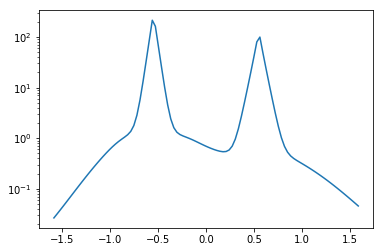

In [76]:
def test_n2():
    grid = get_grid()
    rho = do_run(1.1, np.array([8., 6.]), [], grid)
    plt.semilogy(grid[:, 0]/horton.angstrom, rho)
test_n2()

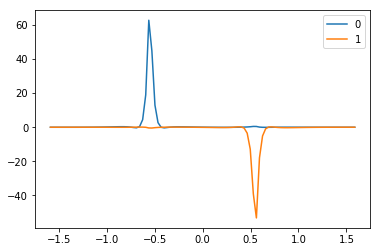

In [92]:
def test_partial_n2_co():
    grid = get_grid()
    targetdist = 1.1
    pseudo = np.array([7., 7.])
    direction = np.array([1., -1.])
    zsuper = []
    
    lvals = np.linspace(0, 1, 10)
    
    # references
    baseline = do_run(1.1, np.array([7., 7.]), [], grid)
    #plt.plot(grid[:, 0]/horton.angstrom, baseline, label='N2')
    target = do_run(1.1, np.array([8., 6.]), [], grid)
    #plt.plot(grid[:, 0]/horton.angstrom, target, lw=2, label='CO')
    
    intvals = []
    for site in (0, 1):
        r_lvals = []
        r_ds = []
        for lval in lvals:
            try:
                d = get_partial_derivative(targetdist, pseudo + direction * lval, zsuper, grid, site)
                r_lvals.append(lval)
                r_ds.append(d)
            except:
                pass
        if r_lvals[0] != 0 or r_lvals[-1] != 1.:
            print (r_lvals)
            raise ValueError('initial or final failed')
        intval = np.trapz(r_ds, r_lvals, axis=0) * direction[site]
        intvals.append(intval)
        plt.plot(grid[:, 0]/horton.angstrom, intval, label=site)
    
    #plt.plot(grid[:, 0]/horton.angstrom, baseline + intvals[0] + intvals[1], label='APDFT')
    plt.legend()
            
test_partial_n2_co()

In [95]:
def partion_charge_change(from_zs, to_zs):
    
    targetdist = 1.1
    lvals = np.linspace(0, 1, 10)
    
    # get integration grid
    coordinates = np.array([[-targetdist/2., 0.0, 0.0], [targetdist/2., 0.0, 0.0]]) * horton.angstrom
    grid = horton.BeckeMolGrid(coordinates, np.array([7,7]), np.array([7,7]), 'fine', mode='keep', random_rotate=False)
    
    # options
    pseudo = np.array(from_zs)
    direction = np.array(to_zs) - np.array(from_zs)
    zsuper = set(list(from_zs) + list(to_zs))
    print (direction)
    
    # get changes
    for site in (0, 1):
        r_lvals = []
        r_ds = []
        for lval in lvals:
            try:
                d = get_partial_derivative(targetdist, pseudo + direction * lval, zsuper, grid.points, site)
                r_lvals.append(lval)
                r_ds.append(d)
            except:
                pass
        if r_lvals[0] != 0 or r_lvals[-1] != 1.:
            print (r_lvals)
            raise ValueError('initial or final failed')
        intval = np.trapz(r_ds, r_lvals, axis=0) * direction[site]
        charge_change = np.sum(intval * grid.weights)
        print (site, charge_change)
partion_charge_change([8, 6], [7, 7])

[-1  1]
(0, 7.455833996972139e-06)
(1, -1.948971548038081e-06)
